In [1]:
import os
from typing import List
from tqdm import tqdm
from numba import jit
from numba.typed import List as NumbaList
import numpy as np
import optuna
import joblib
import matplotlib.pyplot as plt
from time import time
import random
import gc
gc.enable()

from src.fitness import ChessFitness
from src.generator import ChessGenerator
from src.selector import ChessSelector
from src.mutation import ChessMutation
from src.crossover import ChessCrossover

In [2]:
#@jit(nopython=True)
def evaluate(problem_size: int, pop_size: int, iters: int, trials: int, 
             cross_pairs: int, cross_opt_prob: float, mut_mode: int, mut_opt_prob: float, 
             mut_cand_percent: float, ff_age_limit: int = 500, verbose=False) -> List[float]:

    best_fitnesses, best_iters, best_solutions = [], [], []
    for _ in range(trials):
        # Инициализация операторов эволюционного процесса
        generator = ChessGenerator(problem_size)
        ff = ChessFitness(generator.dim)
        selection_oprt = ChessSelector(pop_size, generator.dim)        
        crossover_oprt = ChessCrossover(generator.dim, cross_pairs, cross_opt_prob)
        mutate_oprt = ChessMutation(generator.dim, mut_mode, mut_opt_prob, 
                                     mut_cand_percent)
        
        #print("Инициализация популяции")
        base_pop = generator.get_population(pop_size)

        #print("Старт эволюционного процесса...")
        cur_fitness, flag = [], False
        process = tqdm(range(iters)) if verbose else range(iters)
        for iter_idx in process:

            #          
            if ff.result_age > ff_age_limit:
                flag = True
                break
    
            #
            #print(f"Мутация {base_pop.shape} {base_pop.dtype} кандидатов...")
            old_pop = mutate_oprt.apply(base_pop)
            old_fit = np.array([ff.calculate_fitness(sol) for sol in old_pop], dtype=np.int32)

            #print(f"Кроссовер {old_pop.shape} {old_pop.dtype} кандидатов...")
            new_pop = crossover_oprt.mate(old_pop)
            new_fit = np.array([ff.calculate_fitness(sol) for sol in new_pop], dtype=np.int32)

            union_pop = np.concatenate((old_pop, new_pop))
            union_fit = np.concatenate((old_fit, new_fit))
                
            #print(f"Селекция {union_pop.shape} {union_pop.dtype} кандидатов...")
            base_pop = selection_oprt.filter_population(union_pop, union_fit)

            if verbose:
                process.set_postfix({'ff': ff.best_result})
            cur_fitness.append(ff.best_result)
            ff.result_age += 1

        best_fitnesses.append(cur_fitness)
        best_iters.append( iter_idx+1-ff_age_limit if flag else iter_idx+1 )
        best_solutions.append(np.copy(ff.best_solution))

        #
        del ff
        del selection_oprt
        del crossover_oprt
        del mutate_oprt
        del generator

        del base_pop
        del union_pop
        del union_fit
        del new_pop
        del new_fit
        del old_pop
        del old_fit

        gc.collect()
     
    return best_fitnesses, best_iters, best_solutions

In [3]:
def objective(trial):
    global PROBLEM_SIZE
    global EVALALG_ITERATIONS
    global EVALALG_TRIALS
    global POPULATION_SIZE
    
    gc.collect()

    cross_pairs = trial.suggest_int('cross_pairs', 160, 240, step=40)
    cross_opt_prob = trial.suggest_float("cross_opt_prob", 0, 1, step=0.2)
    mut_mode = trial.suggest_categorical('mut_mode', [0, 1])
    mut_opt_prob = trial.suggest_float("mut_opt_prob", 0, 1, step=0.2)
    mut_cand_percent = trial.suggest_float("mut_opt_percent", 0.6, 1.0, step=0.2)

    #
    best_fitnesses, best_iters, _ = evaluate(PROBLEM_SIZE, POPULATION_SIZE, EVALALG_ITERATIONS, EVALALG_TRIALS, 
                                    cross_pairs, cross_opt_prob, mut_mode, mut_opt_prob, mut_cand_percent)

    mean_fitness = np.mean(list(map(lambda smpl: smpl[-1], best_fitnesses)))
    mean_iters = np.mean(best_iters)

    return mean_fitness, mean_iters

In [4]:
CONFIG = [8] + list(map(lambda v: 8*v, list(range(0, 256, 64))))[1:-1]
print(CONFIG)

[8, 512, 1024]


In [8]:
for i, p_size in enumerate(CONFIG):

    OPTUNA_TRIALS = 10
    PROBLEM_SIZE = p_size
    EVALALG_TRIALS = 2
    EVALALG_ITERATIONS = 2000
    POPULATION_SIZE = 200

    print(PROBLEM_SIZE, EVALALG_ITERATIONS, EVALALG_TRIALS)

    study = optuna.create_study(directions=['minimize', 'minimize'])
    study.optimize(objective, n_trials=OPTUNA_TRIALS, show_progress_bar=True, gc_after_trial=True)

    joblib.dump(study, f"./logs/problem{PROBLEM_SIZE}_optuna_study.pkl")

[I 2024-05-25 18:17:36,249] A new study created in memory with name: no-name-818bc058-aaa6-47c7-b1d1-f8ce0dc82749


8 2000 2


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-05-25 18:17:37,834] Trial 0 finished with values: [0.0, 2.5] and parameters: {'cross_pairs': 160, 'cross_opt_prob': 0.0, 'mut_mode': 1, 'mut_opt_prob': 0.8, 'mut_opt_percent': 1.0}. 
[I 2024-05-25 18:17:39,603] Trial 1 finished with values: [0.0, 2.0] and parameters: {'cross_pairs': 160, 'cross_opt_prob': 0.6000000000000001, 'mut_mode': 1, 'mut_opt_prob': 0.4, 'mut_opt_percent': 0.6}. 
[I 2024-05-25 18:17:42,582] Trial 2 finished with values: [0.0, 3.0] and parameters: {'cross_pairs': 240, 'cross_opt_prob': 0.4, 'mut_mode': 0, 'mut_opt_prob': 0.2, 'mut_opt_percent': 0.6}. 
[I 2024-05-25 18:17:45,116] Trial 3 finished with values: [0.0, 2.5] and parameters: {'cross_pairs': 160, 'cross_opt_prob': 1.0, 'mut_mode': 0, 'mut_opt_prob': 0.2, 'mut_opt_percent': 0.8}. 
[I 2024-05-25 18:17:46,729] Trial 4 finished with values: [0.0, 2.0] and parameters: {'cross_pairs': 160, 'cross_opt_prob': 0.2, 'mut_mode': 1, 'mut_opt_prob': 1.0, 'mut_opt_percent': 0.6}. 
[I 2024-05-25 18:17:48,677] Tr

[I 2024-05-25 18:17:59,307] A new study created in memory with name: no-name-c53f7679-0146-4ac5-aa18-12a8d3d2ed20


[I 2024-05-25 18:17:59,240] Trial 9 finished with values: [0.0, 2.0] and parameters: {'cross_pairs': 240, 'cross_opt_prob': 1.0, 'mut_mode': 0, 'mut_opt_prob': 0.0, 'mut_opt_percent': 0.8}. 
512 2000 2


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-05-25 18:22:25,607] Trial 0 finished with values: [240.5, 575.5] and parameters: {'cross_pairs': 160, 'cross_opt_prob': 0.2, 'mut_mode': 1, 'mut_opt_prob': 0.8, 'mut_opt_percent': 0.6}. 
[I 2024-05-25 18:25:07,561] Trial 1 finished with values: [261.5, 283.5] and parameters: {'cross_pairs': 160, 'cross_opt_prob': 0.0, 'mut_mode': 1, 'mut_opt_prob': 0.8, 'mut_opt_percent': 1.0}. 
[I 2024-05-25 18:41:47,643] Trial 2 finished with values: [0.0, 1061.5] and parameters: {'cross_pairs': 240, 'cross_opt_prob': 1.0, 'mut_mode': 0, 'mut_opt_prob': 1.0, 'mut_opt_percent': 0.6}. 
[I 2024-05-25 18:58:44,925] Trial 3 finished with values: [67.0, 2000.0] and parameters: {'cross_pairs': 200, 'cross_opt_prob': 0.6000000000000001, 'mut_mode': 0, 'mut_opt_prob': 0.0, 'mut_opt_percent': 1.0}. 
[I 2024-05-25 19:02:07,259] Trial 4 finished with values: [259.0, 390.0] and parameters: {'cross_pairs': 200, 'cross_opt_prob': 0.0, 'mut_mode': 1, 'mut_opt_prob': 0.2, 'mut_opt_percent': 1.0}. 
[I 2024-05-

[I 2024-05-25 19:36:37,028] A new study created in memory with name: no-name-b688c0ae-f295-4584-8a4e-5b46f7bf4ac0


[I 2024-05-25 19:36:36,928] Trial 9 finished with values: [237.0, 560.0] and parameters: {'cross_pairs': 200, 'cross_opt_prob': 0.4, 'mut_mode': 1, 'mut_opt_prob': 0.4, 'mut_opt_percent': 1.0}. 
1024 2000 2


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-05-25 20:22:56,690] Trial 0 finished with values: [435.0, 954.5] and parameters: {'cross_pairs': 200, 'cross_opt_prob': 0.6000000000000001, 'mut_mode': 1, 'mut_opt_prob': 1.0, 'mut_opt_percent': 1.0}. 
[I 2024-05-25 21:41:48,350] Trial 1 finished with values: [264.5, 2000.0] and parameters: {'cross_pairs': 200, 'cross_opt_prob': 1.0, 'mut_mode': 1, 'mut_opt_prob': 0.0, 'mut_opt_percent': 0.6}. 
[I 2024-05-25 22:07:15,292] Trial 2 finished with values: [462.5, 574.5] and parameters: {'cross_pairs': 160, 'cross_opt_prob': 0.4, 'mut_mode': 1, 'mut_opt_prob': 1.0, 'mut_opt_percent': 1.0}. 
[I 2024-05-25 23:14:17,539] Trial 3 finished with values: [449.0, 1157.5] and parameters: {'cross_pairs': 200, 'cross_opt_prob': 1.0, 'mut_mode': 1, 'mut_opt_prob': 0.4, 'mut_opt_percent': 0.6}. 
[I 2024-05-26 00:18:19,090] Trial 4 finished with values: [19.5, 2000.0] and parameters: {'cross_pairs': 240, 'cross_opt_prob': 0.4, 'mut_mode': 0, 'mut_opt_prob': 1.0, 'mut_opt_percent': 0.6}. 
[I 2024-

In [35]:
BEST_TRIALS = {
    8: 2,
    512: 1,
    1024: 2
}

INFO = []

In [40]:
CONFIG_IDX = 2
TRIALS = 3

problem_size = CONFIG[CONFIG_IDX]
study = joblib.load(f"./logs/problem{problem_size}_optuna_study.pkl")
PARAMS = study.best_trials[BEST_TRIALS[problem_size]].params

print(problem_size, PARAMS)

start_t = time()

best_fitnesses, best_iters, best_solutions = evaluate(problem_size, 200, 4000, TRIALS, 
                                                      PARAMS['cross_pairs'], PARAMS['cross_opt_prob'],
                                                      PARAMS['mut_mode'], PARAMS['mut_opt_prob'], 
                                                      PARAMS['mut_opt_percent'], ff_age_limit=250, verbose=True)

end_t = time()

elapsed_t = (end_t - start_t) / TRIALS

mean_fitness = np.mean(list(map(lambda v: v[-1], best_fitnesses)))
mean_iters = np.mean(best_iters)
print(mean_fitness, mean_iters, elapsed_t)

INFO.append([problem_size, elapsed_t, mean_iters, mean_fitness])


1024 {'cross_pairs': 200, 'cross_opt_prob': 0.6000000000000001, 'mut_mode': 0, 'mut_opt_prob': 0.4, 'mut_opt_percent': 1.0}


 81%|████████  | 3222/4000 [1:03:04<15:13,  1.17s/it, ff=1] 

1.3333333333333333 2570.6666666666665 3360.344160795212


In [41]:
INFO

[[8, 1.0879216194152832, 3.6666666666666665, 0.0],
 [512, 484.16797137260437, 1219.3333333333333, 0.0],
 [1024, 3360.344160795212, 2570.6666666666665, 1.3333333333333333]]

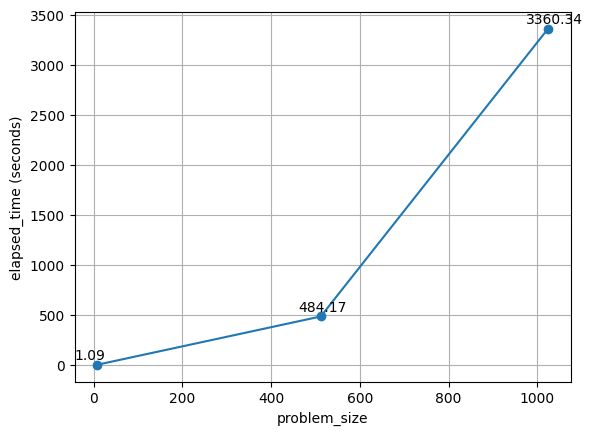

In [52]:
x = list(map(lambda v: v[0],INFO))
y = list(map(lambda v: v[1],INFO))
plt.plot(x,y, marker='o')
for x_i, y_i in zip(x,y):
    plt.text(x_i - 50, y_i + 50, str(round(y_i, 2)))
plt.xlabel('problem_size')
plt.ylabel('elapsed_time (seconds)')
plt.grid()
plt.savefig("fit_time_compare.jpeg")

plt.show()



In [ ]:
x = list(map(lambda v: v[0],INFO))
y = list(map(lambda v: v[-1],INFO))
plt.plot(x,y, maeker='o')
plt.xlabel('problem_size')
plt.ylabel('fitness-value')
plt.grid()
plt.show()

In [19]:

best_fitnesses, best_iters, best_solutions = evaluate(8, 200, 4000, 10, 
                                                      240, 0.5, 0, 0.5, 1.0, verbose=True)

 13%|█▎        | 501/4000 [00:02<00:14, 245.94it/s, ff=0]
